In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm

### Identify the Leakage time

In [66]:
data = np.load("data/traces_mso5074_preproc.npz", allow_pickle=True)
print(data.files)
print(data['ciphertexts'].dtype)
print(f"Shape of traces captured is {data['waves'].shape}")
print(f"Shape of ciphertext data is {data['ciphertexts'].shape}")
print(f"Shape of plaintext data is {data['plaintexts'].shape}")

['waves', 'meta_start', 'meta_end', 'plaintexts', 'ciphertexts', 'keys']
uint8
Shape of traces captured is (5000, 216)
Shape of ciphertext data is (5000, 16)
Shape of plaintext data is (5000, 16)


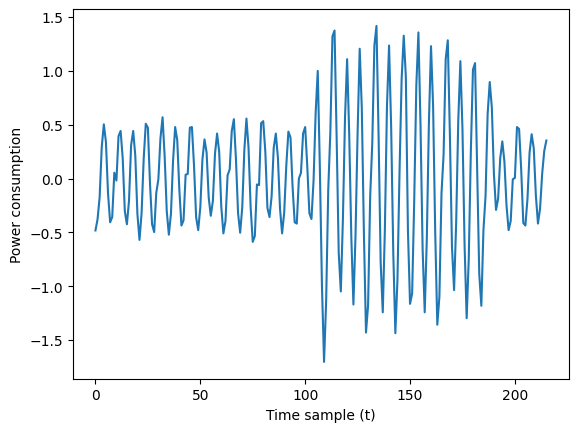

In [67]:
traces = data['waves']
plaintexts = data['plaintexts']
ciphertexts = data['ciphertexts']
# Average all traces to reduce noise
avg_trace = np.mean(traces, axis=0)  # Shape: (200,)

# Plot the averaged trace
plt.plot(avg_trace)
plt.xlabel("Time sample (t)")
plt.ylabel("Power consumption")
plt.show()

### Automatic Peak Detection with Statistics

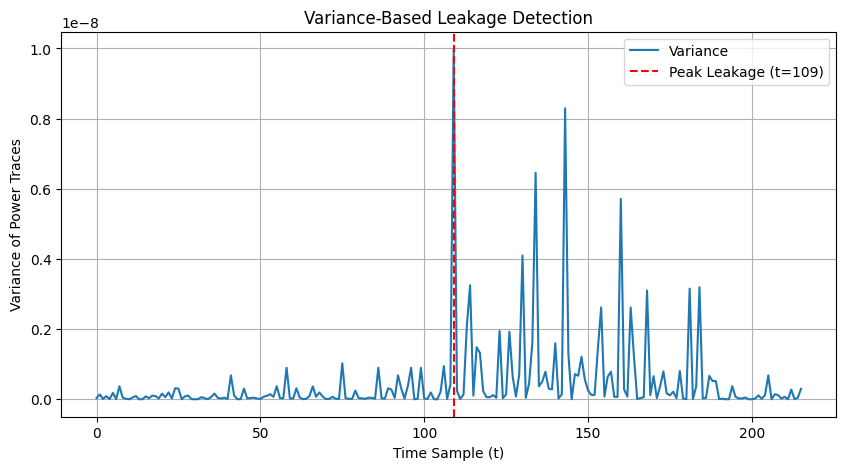

Detected leakage at time sample t = 109


In [68]:
# Compute variance across all traces at each time sample
variance_per_time = np.var(traces, axis=0)  # Shape: (200,)

# Find the time sample with highest variance (most likely leakage point)
leakage_time = np.argmax(variance_per_time)

# Plot variance vs. time to visualize leakage
plt.figure(figsize=(10, 5))
plt.plot(variance_per_time, label='Variance')
plt.axvline(x=leakage_time, color='r', linestyle='--', label=f'Peak Leakage (t={leakage_time})')
plt.xlabel('Time Sample (t)')
plt.ylabel('Variance of Power Traces')
plt.title('Variance-Based Leakage Detection')
plt.legend()
plt.grid()
plt.show()

print(f"Detected leakage at time sample t = {leakage_time}")

In [69]:
# Important Configurations

# AES S-box (for reference)
AES_SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
], dtype=np.uint8)

# AES Inverse S-Box (for last-round attack)
INV_S_BOX = np.array([
    0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
    0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
    0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
    0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
    0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
    0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
    0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
    0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
    0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
    0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
    0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
    0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
    0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
    0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
    0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d
])


# Hamming weight lookup table (0-255)
HW_TABLE = np.array([bin(x).count("1") for x in range(256)])

# ShiftRows inverse permutation (for last round)
INV_SHIFT_ROWS = [0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11]

# True key only used for comparison
true_key = np.array([0x10, 0xa5, 0x88, 0x69, 0xd7, 0x4b, 0xe5, 0xa3,
                         0x74, 0xcf, 0x86, 0x7c, 0xfb, 0x47, 0x38, 0x59], dtype=np.uint8)

In [70]:
def hamming_weight(x):
    """Compute Hamming Weight (number of set bits)."""
    return bin(x).count('1')

def hamming_distance(x, y):
    """Compute Hamming Distance between two bytes."""
    return hamming_weight(x ^ y)

In [71]:
def reverse_last_round(ciphertext, last_round_key):
    """
    Reverse last round operations to get input state.
    Args:
        ciphertext (np.ndarray): 16-byte ciphertext.
        last_round_key (np.ndarray): 16-byte Round 10 key.
    Returns:
        np.ndarray: Input state to last round (16 bytes).
    """
    state = np.zeros(16, dtype=np.uint8)
    for i in range(16):
        # Inverse ShiftRows
        shifted_pos = INV_SHIFT_ROWS[i]
        # Inverse SubBytes (S-box) and XOR with key
        state[i] = INV_S_BOX[ciphertext[shifted_pos]] ^ last_round_key[shifted_pos]
    return state

In [72]:
def last_round_hd_leakage(ciphertext, key_guess_byte, byte_pos, last_round_key_guess):
    """
    Compute Hamming Distance for a guessed key byte.
    Args:
        ciphertext (np.ndarray): 16-byte ciphertext.
        key_guess_byte (int): Candidate key byte (0-255).
        byte_pos (int): Position of the key byte (0-15).
        last_round_key_guess (np.ndarray): Current guess for last round key (16 bytes).
    Returns:
        int: Hamming Distance between input and output of last round.
    """
    # Reverse last round to get input state
    input_state = reverse_last_round(ciphertext, last_round_key_guess)
    # Compute S-box output (last round operation)
    sbox_out = AES_SBOX[input_state[byte_pos] ^ key_guess_byte]
    # HD = HammingWeight(input_state[byte_pos] ⊕ sbox_out)
    return hamming_distance(input_state[byte_pos], sbox_out)

In [73]:
def reverse_key_scheduling(last_round_key):
    """
    Reverse AES key scheduling to recover original key.
    Args:
        last_round_key (list): 16-byte Round 10 key.
    Returns:
        np.ndarray: Original AES-128 key (16 bytes).
    """
    # (Implementation depends on AES key schedule)
    # For simplicity, assume last_round_key is original key (if no key expansion)
    return last_round_key  # Replace with actual inverse key schedule

In [74]:
def cpa_hd_attack(traces, ciphertexts):
    """
    CPA attack using Hamming Distance (HD) model.
    Args:
        traces (np.ndarray): Power traces (shape: num_traces x num_samples).
        ciphertexts (np.ndarray): Ciphertexts (shape: num_traces x 16).
    Returns:
        list: Best key guesses for each byte (0-15).
        np.ndarray: Correlation traces (256 x 16 x num_samples).
    """
    num_traces, num_samples = traces.shape
    key_guesses = np.zeros(16, dtype=np.uint8)
    correlations = np.zeros((256, 16, num_samples))
    last_round_key_guess = np.zeros(16, dtype=np.uint8)  # Initialize key guess

    for byte in tqdm(range(16), desc="Attacking key bytes (HD)"):
        for kg in range(256):  # Brute-force key guesses (0-255)
            hypothetical = np.zeros(num_traces)
            last_round_key_guess[byte] = kg  # Update current key guess

            for trace_idx in range(num_traces):
                # Compute HD leakage
                hypothetical[trace_idx] = last_round_hd_leakage(
                    ciphertexts[trace_idx], kg, byte, last_round_key_guess
                )

            # Compute correlation for all time samples
            for sample in range(num_samples):
                corr, _ = pearsonr(hypothetical, traces[:, sample])
                correlations[kg, byte, sample] = abs(corr)

        # Best key guess = max correlation
        best_kg = np.argmax(np.max(correlations[:, byte, :], axis=1))
        key_guesses[byte] = best_kg
        last_round_key_guess[byte] = best_kg  # Update final key guess

    return key_guesses, correlations

In [75]:
# Run CPA with HD model
hd_key, hd_corr = cpa_hd_attack(traces, ciphertexts)

# Recover original key
original_key_hd = reverse_key_scheduling(hd_key)


Attacking key bytes (HD):   0%|          | 0/16 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_5420\727165053.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(hypothetical, traces[:, sample])
Attacking key bytes (HD): 100%|██████████| 16/16 [20:53<00:00, 78.36s/it]


In [81]:
print("Recovered Key (HD):", "".join(f"{b:02x}" for b in original_key_hd))

Recovered Key (HD): 00000000000000000000000000000000


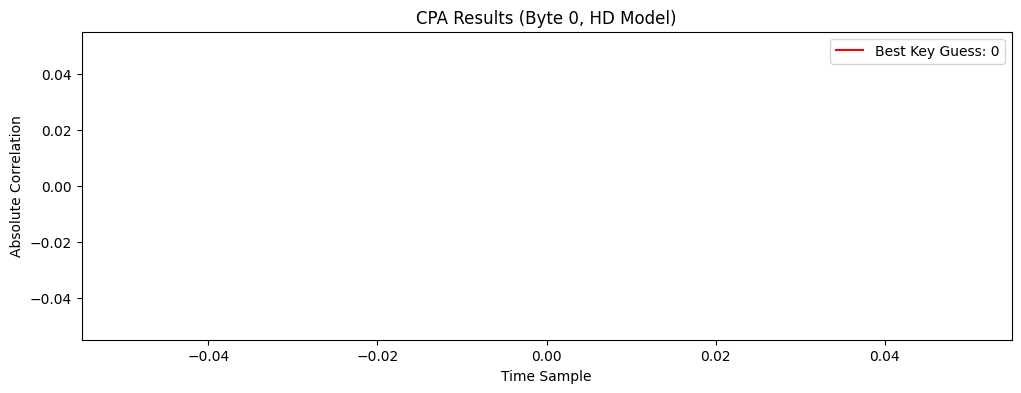

In [41]:
def plot_correlation(correlations, byte, model):
    """Plot correlation traces for a given key byte."""
    plt.figure(figsize=(12, 4))
    for kg in range(256):
        plt.plot(correlations[kg, byte, :], alpha=0.1, color="gray")
    best_kg = np.argmax(np.max(correlations[:, byte, :], axis=1))
    plt.plot(correlations[best_kg, byte, :], color="red", label=f"Best Key Guess: {best_kg}")
    plt.title(f"CPA Results (Byte {byte}, {model} Model)")
    plt.xlabel("Time Sample")
    plt.ylabel("Absolute Correlation")
    plt.legend()
    plt.show()

# Example: Plot correlation for Byte 0 (HW model)
plot_correlation(hd_corr, byte=0, model="HD")